# Unsupervised learning
# Implement ITUC's AutoEncoder + k-Means clustering approach

Start with Test 1 Bearings 3x and 4x, which ended in failure.

In [ ]:
# Needed older version of numpy for tensorflow to work
#!pip install numpy==1.23.4 --user

In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.fft import rfft, rfftfreq
from scipy import signal
import sklearn
import os
import matplotlib.pyplot as plt
import inspect

In [2]:
print(np.__version__)

1.23.4


In [3]:
# Load tensorflow's keras package
import tensorflow as tf
from tensorflow import keras

### AutoEncoder

Implement Juodelyte, et. al.'s exact [AutoEncoder](https://github.com/DovileDo/BearingDegradationStageDetection/blob/main/src/models/AutoEncoder.py) architecture as a starting point, to replicate their methodology on the new IMS bearing dataset.

In [4]:
# Import the ITUC AutoEncoder creation script
    # Source: https://github.com/DovileDo/BearingDegradationStageDetection/blob/main/src/models/AutoEncoder.py
import AutoEncoder
from AutoEncoder import anomaly_score # obtain anomaly score for each observation
from AutoEncoder import calc_anomaly_treshold # set threshold score to identify anomalous values indicative of final failure stage
from AutoEncoder import correct_labels # reorder cluster labels in chronological order
from AutoEncoder import get_AElabels # train the AutoEncoder and k-means clustering algorithm and output the result 

The AutoEncoder input layer is updated from length 641 to 1025 to reflect the different signal frequency. IMS data was recorded at 20,480 and then down-sampled by a factor of 10 to 2,048 Hz.  When transformed to the frequency domain via Fast Fourier Transform (FFT), the data takes the shape of a matrix of size n * p, where:
 - **n** is the number of observations in each Test, and
 - **p** = ((f * s)/2) + 1 = ((20480 * 0.1)/2) + 1 = 1025.
     - **f** is the frequency (20,480 Hz)
     - **s** is the sampling rate (0.1, meaning down-sampling by a factor of 10).  

In [5]:
# Update AutoEncoder architecture

input_freq = keras.Input(shape=(1025,))
# "encoded" is the encoded representation of the input
encoded = keras.layers.Dense(256, activation="relu")(input_freq)
encoded = keras.layers.Dense(128, activation="relu")(encoded)
encoded = keras.layers.Dense(64, activation="relu")(encoded)
encoded = keras.layers.Dense(32, activation="relu")(encoded)
encoded = keras.layers.Dense(8, activation="relu")(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = keras.layers.Dense(8, activation="relu")(encoded)
decoded = keras.layers.Dense(32, activation="relu")(decoded)
decoded = keras.layers.Dense(64, activation="relu")(decoded)
decoded = keras.layers.Dense(128, activation="relu")(decoded)
decoded = keras.layers.Dense(1025, activation="linear")(decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_freq, decoded)
# This model maps an input to its encoded representation
encoder = keras.Model(input_freq, encoded)
weights = autoencoder.get_weights()
autoencoder.compile(optimizer="adam", loss="mae")

### Update ITUC AutoEncoder functions
The FEMTO dataset used by the ITUC team included both vertical (y-axis) and horizontal (x-axis) vibration signal. The IMS dataset I used includes only horizontal signal for Tests 2 and 3, so I excluded the vertical signal in Test 1 from my analysis.  The ITUC AutoEncoder implementation must be updated to exclude the vertical vibration encoding.

Also update the function to enable custom setting the value of "k", or the parameter that determines the number of cluster trained by the k-means clustering algorithm.

In [6]:
# Print function
lines = inspect.getsource(get_AElabels)
print(lines)

def get_AElabels(Xt, Xf):
    autoencoder.set_weights(weights)
    autoencoder.fit(
        Xt[:, :641], Xt[:, :641], epochs=100, batch_size=64, shuffle=True, verbose=False
    )

    # Horizontal vibration encoding
    Hencoded_f = encoder.predict(Xt[:, :641])

    Hdecoded_f = autoencoder.predict(Xf[:, :641])
    score = anomaly_score(Xf[:, :641], Hdecoded_f)
    anomaly_threshold = calc_anomaly_treshold(
        anomaly_score(Xt[:, :641], autoencoder.predict(Xt[:, :641]))
    )

    autoencoder.set_weights(weights)
    autoencoder.fit(
        Xt[:, 641:], Xt[:, 641:], epochs=100, batch_size=64, shuffle=True, verbose=False
    )

    # Vertical vibration encoding
    Vencoded_f = encoder.predict(Xt[:, 641:])

    Encoding = np.concatenate((Hencoded_f, Vencoded_f), axis=1)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(Encoding)
    kMeanslabels = kmeans.labels_

    Alabels = np.where(score > anomaly_threshold, 1, 0)

    return correct_labels(kMeanslabels, Alabels)



In [7]:
# Update get_AElabels function to include ONLY horizontal vibration signal
def get_AElabels(Xt, Xf, k=3):
    autoencoder.set_weights(weights)
    autoencoder.fit(
        Xt, Xf, epochs=100, batch_size=64, shuffle=True, verbose=False
    )

    # Horizontal vibration encoding
    Hencoded_f = encoder.predict(Xt)

    Hdecoded_f = autoencoder.predict(Xf)
    score = anomaly_score(Xf, Hdecoded_f)
    anomaly_threshold = calc_anomaly_treshold(
        anomaly_score(Xt, autoencoder.predict(Xt))
    )

    #Encoding = np.concatenate((Hencoded_f, Vencoded_f), axis=1)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Hencoded_f) #Encoding
    kMeanslabels = kmeans.labels_

    Alabels = np.where(score > anomaly_threshold, 1, 0)

    return correct_labels(kMeanslabels, Alabels)

In [8]:
# Print function
lines = inspect.getsource(correct_labels)
print(lines)

def correct_labels(Hl, Al):
    labelsb = Al
    labelsb = np.where(labelsb == 1, 3, 2)
    avg = []
    for i in range(3):
        avg.append(np.sum(np.where(Hl == i)) / len(np.where(Hl == i)[0]))
    new = np.copy(Hl)
    for i in range(3):
        idx = np.argmin(avg)
        new[np.where(Hl == idx)] = i
        avg[idx] = float("inf")
    labelsb[: Hl.shape[0]] = new
    return labelsb



In [9]:
def correct_labels(Hl, Al):
    labelsb = Al
    labelsb = np.where(labelsb == 1, 3, 2)
    avg = []
    for i in range(3):
        if len(np.where(Hl == i)[0]) > 0:
            avg.append(np.sum(np.where(Hl == i)) / len(np.where(Hl == i)[0]))
        else:
            avg.append(0)
    new = np.copy(Hl)
    for i in range(3):
        idx = np.argmin(avg)
        new[np.where(Hl == idx)] = i
        avg[idx] = float("inf")
    labelsb[: Hl.shape[0]] = new
    return labelsb

# Test 1 Bearing 3x

### Manual labels
- Exclude Obs. 0-159 (data error)
- Stage 1 (healthy) - until EMA of kurtosis spikes, excluding the initial data issue. (Obs 160-1825) (Index 1665)
- Stage 2 (faulty) - from when EMA of kurtosis spikes until absolute mean spikes (Obs 1826-2153). (Index 1993)
- Stage 3 (failed) - absolute mean spikes at the very end of the series (Obs 2154-2155).

In [10]:
fft_b3x_ds10 = pd.read_csv("Data/IMS/FFT/fft_b3x_ds10.csv", header=None)
fft_b3x_ds10 = fft_b3x_ds10.iloc[160:,] # Truncate first 160 observations based on EDA
fft_b3x_ds10.shape

(1996, 1025)

In [11]:
t1_b3x_clstr = get_AElabels(fft_b3x_ds10, fft_b3x_ds10)

C:\Users\nadav.rindler\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
# Counts of each cluster label
np.unique(t1_b3x_clstr, return_counts=True)

(array([0, 1, 2]), array([1963,   29,    4], dtype=int64))

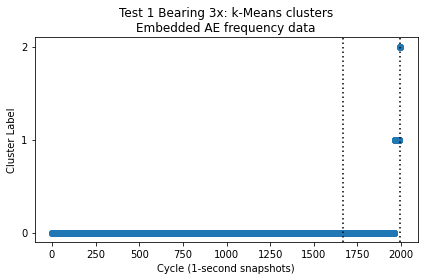

In [13]:
# Plot k-means cluster label assignments over time
plt.figure(figsize=(6,4))
plt.scatter(y=t1_b3x_clstr, x=range(len(t1_b3x_clstr))) 
plt.axvline(x=1665, color="black", dashes=(1,2))
plt.axvline(x=1993, color="black", dashes=(1,2))
plt.yticks(range(3))
plt.ylabel("Cluster Label")
plt.xlabel("Cycle (1-second snapshots)")
plt.title("Test 1 Bearing 3x: k-Means clusters\nEmbedded AE frequency data")
plt.tight_layout()
plt.show()

### Alternative 1: Truncate last 20% of data with final failure stage
Following ITUC methodology.

In [14]:
fft_b3x_trunc = fft_b3x_ds10.iloc[:-200,] # Truncate last 20% of observations which include the failure stage
fft_b3x_trunc.reset_index(drop=True, inplace=True)
fft_b3x_trunc.shape

(1796, 1025)

In [15]:
t1_b3x_trunc_clstr = get_AElabels(fft_b3x_trunc, fft_b3x_trunc, k=2)

C:\Users\nadav.rindler\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
# Counts of each cluster label
np.unique(t1_b3x_trunc_clstr, return_counts=True)

(array([1, 2]), array([1013,  783], dtype=int64))

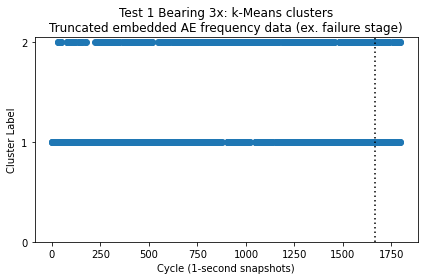

In [17]:
# Plot k-means cluster label assignments over time
plt.figure(figsize=(6,4))
plt.scatter(y=t1_b3x_trunc_clstr, x=range(len(t1_b3x_trunc_clstr))) 
plt.axvline(x=1665, color="black", dashes=(1,2))
plt.yticks(range(3))
plt.ylabel("Cluster Label")
plt.xlabel("Cycle (1-second snapshots)")
plt.title("Test 1 Bearing 3x: k-Means clusters\nTruncated embedded AE frequency data (ex. failure stage)")
plt.tight_layout()
plt.show()

### Alternative 2: Apply k-Means clustering on raw frequency data
Do not use the AutoEncoder embedding.

In [18]:
km_b3x = KMeans(n_clusters=3, random_state=0).fit(fft_b3x_ds10)
km_b3x_labs = km_b3x.labels_

C:\Users\nadav.rindler\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
# Counts of each cluster label
np.unique(km_b3x_labs, return_counts=True)

(array([0, 1, 2]), array([1183,  812,    1], dtype=int64))

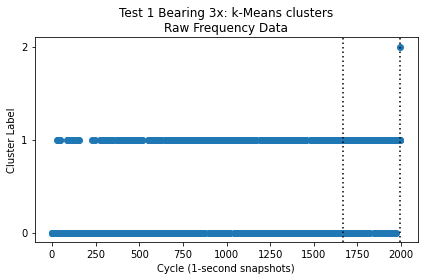

In [20]:
# Plot k-means cluster label assignments over time
plt.figure(figsize=(6,4))
plt.scatter(y=km_b3x_labs, x=range(len(km_b3x_labs))) 
plt.axvline(x=1665, color="black", dashes=(1,2))
plt.axvline(x=1993, color="black", dashes=(1,2))
plt.yticks(range(3))
plt.ylabel("Cluster Label")
plt.xlabel("Cycle (1-second snapshots)")
plt.title("Test 1 Bearing 3x: k-Means clusters\nRaw Frequency Data")
plt.tight_layout()
plt.show()

### Alternative 3: Other clustering algorithms
 - Hierarchical clustering
 - DBScan
 
Try on both embedded (AutoEncoder) data and on raw frequency data

**Hierarchical clustering**

In [21]:
autoencoder.set_weights(weights)
autoencoder.fit(fft_b3x_ds10, fft_b3x_ds10, epochs=100, batch_size=64, shuffle=True, verbose=False)
Hencoded_f = encoder.predict(fft_b3x_ds10)

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [23]:
# Use embedded AE data
complete_clustering = linkage(Hencoded_f, method="complete", metric="euclidean") #, optimal_ordering=True

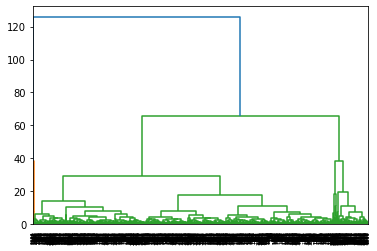

In [24]:
dendrogram(complete_clustering)
plt.show()

In [25]:
# Use raw frequency data
complete_clustering = linkage(fft_b3x_ds10, method="complete", metric="euclidean") #, optimal_ordering=True

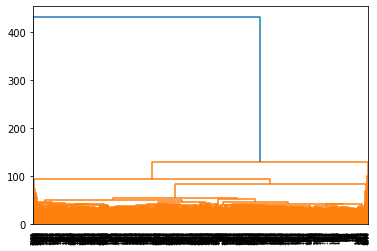

In [26]:
dendrogram(complete_clustering)
plt.show()

Hierarchical clustering fails to show any meaningful structure (clusters) in the data.

### DBScan

In [27]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [28]:
# Use embedded AE data
db = DBSCAN(eps=0.5, min_samples=10).fit(Hencoded_f)
db_labs = db.labels_

In [29]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labs)) - (1 if -1 in db_labs else 0)
n_noise_ = list(db_labs).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 541


In [30]:
np.unique(db_labs, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([ 541,   87, 1193,    4,   77,   84,   10], dtype=int64))

In [31]:
# Use raw frequency data
db = DBSCAN(eps=0.5, min_samples=10).fit(fft_b3x_ds10)
db_labs = db.labels_

In [32]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labs)) - (1 if -1 in db_labs else 0)
n_noise_ = list(db_labs).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 1996


In [33]:
np.unique(db_labs, return_counts=True)

(array([-1], dtype=int64), array([1996], dtype=int64))

DBScan can find some segments within the data, but it is very sensitive to the input parameters (eps and min_samples). Grid search across the parameter space may help here. But I'm not seeing clear clusters jump out.

### Alternative 4: Include a time series trend component

Include row count as a column to introduce the ordered nature of the time series data.

In [34]:
fft_b3x_ds10.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024],
           dtype='int64', length=1025)

In [35]:
fft_b3x_ds10[1025] = fft_b3x_ds10.index

In [36]:
km_b3x = KMeans(n_clusters=3, random_state=0).fit(fft_b3x_ds10)
km_b3x_labs = km_b3x.labels_

C:\Users\nadav.rindler\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [37]:
# Counts of each cluster label
np.unique(km_b3x_labs, return_counts=True)

(array([0, 1, 2]), array([665, 666, 665], dtype=int64))

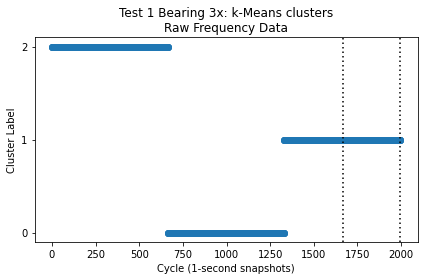

In [38]:
# Plot k-means cluster label assignments over time
plt.figure(figsize=(6,4))
plt.scatter(y=km_b3x_labs, x=range(len(km_b3x_labs))) 
plt.axvline(x=1665, color="black", dashes=(1,2))
plt.axvline(x=1993, color="black", dashes=(1,2))
plt.yticks(range(3))
plt.ylabel("Cluster Label")
plt.xlabel("Cycle (1-second snapshots)")
plt.title("Test 1 Bearing 3x: k-Means clusters\nRaw Frequency Data")
plt.tight_layout()
plt.show()

In [39]:
# Drop ts row-counter column
fft_b3x_ds10.drop([1025], axis=1, inplace=True)

Nice! Including a time series trend component results in the k-means clustering algorithm outputting sequential, non-overlapping cluster labels (the order of the labels 2, 0, and then 1 does not matter).  The **problem**, however, is that each of the three clusters have the **exact same number of observations**.  This negates the objective of using the transition from one cluster to the next to signify a transition in bearing state from healthy-->faulty, or faulty-->failed.  We need to *learn* the appropriate changepoint from the data itself.

### Alternative 5: Train the clustering algorithm on time-domain features instead of frequency-domain features

In [40]:
ts_b3x_ds10 = pd.read_csv("Data/IMS/TS/ts_b3x_ds10.csv", header=None)
ts_b3x_ds10 = ts_b3x_ds10.iloc[160:2154,] # Truncate first 160 obs. because of data error
ts_b3x_ds10.shape

(1994, 21)

In [41]:
km_b3x = KMeans(n_clusters=3, random_state=0).fit(ts_b3x_ds10)
km_b3x_labs = km_b3x.labels_

C:\Users\nadav.rindler\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [42]:
# Counts of each cluster label
np.unique(km_b3x_labs, return_counts=True)

(array([0, 1, 2]), array([1960,   18,   16], dtype=int64))

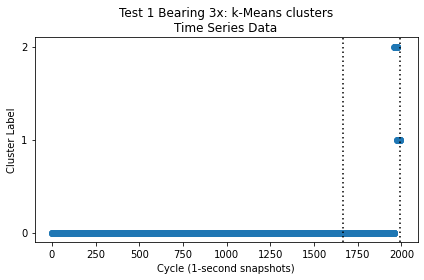

In [43]:
# Plot k-means cluster label assignments over time
plt.figure(figsize=(6,4))
plt.scatter(y=km_b3x_labs, x=range(len(km_b3x_labs))) 
plt.axvline(x=1665, color="black", dashes=(1,2))
plt.axvline(x=1993, color="black", dashes=(1,2))
plt.yticks(range(3))
plt.ylabel("Cluster Label")
plt.xlabel("Cycle (1-second snapshots)")
plt.title("Test 1 Bearing 3x: k-Means clusters\nTime Series Data")
plt.tight_layout()
plt.show()

### Alternative 6: Test additional bearings

# Test 1 Bearing 4x

### Manual labels
 - Stage 1 (healthy) - until EMA of kurtosis spikes, excluding the initial data issue. (Obs 160-1466) (Index 1306)
 - Stage 2 (faulty) - from when EMA of kurtosis spikes until it drops again (Obs 1467-1849). (Index 1689)
 - Stage 3 (failed) - the remainder of the series (Obs 1850-1996).

In [44]:
fft_b4x_ds10 = pd.read_csv("Data/IMS/FFT/fft_b4x_ds10.csv", header=None)
fft_b4x_ds10 = fft_b4x_ds10.iloc[160:,] # Truncate first 160 observations based on EDA
fft_b4x_ds10.shape

(1996, 1025)

In [45]:
t1_b4x_clstr = get_AElabels(fft_b4x_ds10, fft_b4x_ds10)

C:\Users\nadav.rindler\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
# Counts of each cluster label
np.unique(t1_b4x_clstr, return_counts=True)

(array([0, 1, 2]), array([624, 884, 488], dtype=int64))

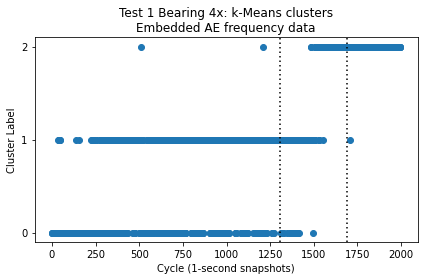

In [47]:
# Plot k-means cluster label assignments over time
plt.figure(figsize=(6,4))
plt.scatter(y=t1_b4x_clstr, x=range(len(t1_b4x_clstr))) 
plt.axvline(x=1306, color="black", dashes=(1,2))
plt.axvline(x=1689, color="black", dashes=(1,2))
plt.yticks(range(3))
plt.ylabel("Cluster Label")
plt.xlabel("Cycle (1-second snapshots)")
plt.title("Test 1 Bearing 4x: k-Means clusters\nEmbedded AE frequency data")
plt.tight_layout()
plt.show()

### Note
I tried all 5 additional alternatives for Test 1 Bearing 4x, but have not included the code here because I ran out of time to clean up and organize the code. The result was the same as for Test 1 Bearing 3x - I was not able to achieve sequential, non-overlapping cluster labels that would indicate successive changes of bearing state (healthy-->faulty and faulty-->failed). 